<center>

# Проект на тему "Поиск экзопланет"
</center>

## Введение

Экзопланеты - планеты, находящиеся вне Солнечной системы. Наш проект направлен на анализ датасета, посвященного поиску экзопланет при помощи орбитальной обсерватории Кеплер. В ходе работы мы визуализируем наши данные, проверим гипотезы, составленные на основе EDA и обучим модели классификаторов для определения значения целевой переменной по признаковому описанию объекта.

## Часть 1: Импорт необходимых библиотек и загрузка датасета

Выбранный нами [датасет](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative) был взят с сайта NASA. К нашему сожалению или счастью, он обладает исчерпывающей информацией обо всех точках интереса обсерватории Кеплер (Kepler Objects of Interest, `KOI`). 

Каждому рассматриваемому телу соответсвует отдельная строка в датасете, хранящая информацию о статусе тела в рамках программы по поиску экзопланет, а также характеристики самого тела и его "звезды-хозяина".

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts

from scipy.stats import pearsonr
from scipy.stats import f_oneway
from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('cumulative.csv')

# Выведем размер нашего датасета
print(df.shape)

df.head()

(9564, 50)


,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


## Часть 2: Предварительная обработка данных

### Описание колонок

Рассмотрим столбцы нашего датасета, приведем их описание на основании [документации](https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html). Это долгий, но необходимый процесс, так как наш датасет имеет большое количество колонок, и разбор значений каждой позволит нам отбросить очевидно нерелевантные переменные: 

- `kepid`: KepID - уникальный идентификационный номер, присвоенный звезде, около которой ведется поиск планеты. Т.е. несколько тел в нашем датасете могут иметь один KepID, это будет означать, что они обращаются вокруг одной звезды.

- `kepoi_name`: KOI Name - имя-код, присваиваемое объекту интереса Кеплера (далее `KOI`). Если считанные данные похожи на транзит, гипотетической планете присваивается KOI Name.

- `kepler_name` - Имя, присваиваемое объекту, после подтверждения его статуса экзопланеты.

- `koi_disposition` - Финальный вердикт команды Kepler относительно того, является ли объект экзопланетой. Возможные значения: CONFIRMED - объект является экзопланетой, FALSE POSITIVE - объект не является экзопланетой, CANDIDATE - статус объекта еще не определен.

- `koi_pdisposition` - Начальное решение команды Kepler относительно того, является ли объект кандидатом в экзопланеты или нет. Возможные значения: CANDIDATE, FALSE POSITIVE.

- `koi_score` - Степень уверенности команды в принятом решении `koi_pdisposition`. Принимает значения от 0 до 1, где большее значение соответсвует большему уровню уверенности.

- `koi_fpflag_nt` - Принимает значение 1, в случае, если кривая блеска объекта не похожа на кривую блеска транзитной планеты (включает случаи артефактов или большой зашумленности данных), в противном случае - 0.

- `koi_fpflag_ss` - Принимает значение 1, в случае, если данные об объекте выглядят смешанными со вторичными (например в случае с двузвездными системами), в протвином случае - 0.

- `koi_fpflag_co` - Принимает значение 1, в случае, если источником сигнала является близлежайшая звезда (высчитывается физически), в противном случае - 0.

- `koi_fpflag_ec` - Принимает значение 1, в случае, если объект имеет тот же период и другие характеристики, что и какой-то другой объект, в противном случае - 0.

- `koi_period` - Интервал между транзитами (Дни).

- `koi_time0bk` - Время, соответсвующее центру первого транзита в барицентрический юлианский день (юлианская дата, скорректированная с учетом различий в положении Земли относительно барицентра Солнечной системы. Из-за конечной скорости света время наблюдения астрономического события зависит от изменения положения наблюдателя в Солнечной системе).

- `koi_impact` - Небесно-проекционное расстояние между центром диска звезды и центром диска объекта, разделенное на радиус звезды. Например, расстояние равное 0 означает, что планета проходит точно перед центром звезды.

- `koi_duration` - Продолжительность наблюдаемого транзита (Часы).

- `koi_depth` - Доля звездного потока, потерянного в момент нахождения объекта между наблюдателем и звездой. Переменная показывает насколько планета блокирует свет звезды. Чем больше значение - тем больше света заблокировано.

- `koi_prad` - Радиус объекта (в радиусах Земли). Если значение равно 1 - объект имеет радиус, равный радусу Земли, если 10 - десяти радиусам Земли и т.д.

- `koi_teq` - Приблизительная температура объекта (Кельвины).

- `koi_insol` - Другой способ задать температуру, относительно кол-ва тепла, получаемого Землей от Солнца. Если значение равно 1 - объект получает столько же тепла, сколько и Земля от Солнца, если 2 - в 2 раза больше и т.д.

- `koi_model_snr` - Отношение полученного сигнала об объекте к шуму. Считается при помощи `koi_depth`.

- `koi_tce_plnt_num` и `koi_tce_delivname` - служебные номерные переменные. 

- `koi_steff` - Температура звезды (Кельвины).

- `koi_slogg` - Поверхностная гравитация звезды. Показывает насколько сильно объекты притягиваются к поверхности звезды. Чем больше значение, тем сильнее гравитация на поверхности звезды и тем больше масса звезды.

- `koi_srad` - Радиус звезды (в радиусах Солнца).

- `ra` - Координата, используемая для указания положения объекта на небесной сфере (Градусы).

- `dec` - Координата, используемая для указания положения объекта на небесной сфере (Градусы).

- `koi_kepmag` - Яркость звезды, вокруг которой обращается объект в полосе Кеплера (система, разработанная для телескопа). Чем больше значение - тем ярче звезда.

Также ряд переменных имеют соответствующие им пары переменных, оканчивающиеся на `_err1` и `_err2` (например: koi_period, koi_period_err1, koi_period_err2). err1 и err2 представляют собой верхнюю и нижнюю границы ошибки измерения для соответсвующего значения. 

### Удаление нерелевантных столбцов

Избавимся от столбцов, которые несут информацию о точности измерений, а также избыточных фактах, вроде координат объекта на небесной сфере.

In [36]:
# Получим список всех столбцов, содержащих границы ошибок измерения и удалим их
err_columns = [col for col in df.columns if col.endswith('_err1') or col.endswith('_err2')]
df = df.drop(columns=err_columns)

# Удалим столбцы с индексацией строк, а также с координатами на небесной сфере
df = df.drop(columns=['rowid', 'ra', 'dec'])

# Удалим столбцы со служебной информацией
df = df.drop(columns=['koi_tce_plnt_num', 'koi_tce_delivname'])

# Удалим столбцы с предварительным результатом, а также степенью уверенности в нем
df = df.drop(columns=['koi_pdisposition', 'koi_score'])

# Удалим столбец с именем звезды-хозяина
df = df.drop(columns=['kepid'])

Уберем префикс `'koi_'` из начала имен столбцов и выведем измененный DataFrame.

In [37]:
df.columns = [col.replace('koi_', '') for col in df.columns]

print(df.shape)
df.head()

(9564, 20)


,kepoi_name,kepler_name,disposition,fpflag_nt,fpflag_ss,fpflag_co,fpflag_ec,period,time0bk,impact,duration,depth,prad,teq,insol,model_snr,steff,slogg,srad,kepmag
0,K00752.01,Kepler-227 b,CONFIRMED,0,0,0,0,9.488036,170.538750,0.146,2.95750,615.8,2.26,793.0,93.59,35.8,5455.0,4.467,0.927,15.347
1,K00752.02,Kepler-227 c,CONFIRMED,0,0,0,0,54.418383,162.513840,0.586,4.50700,874.8,2.83,443.0,9.11,25.8,5455.0,4.467,0.927,15.347
2,K00753.01,NaN,FALSE POSITIVE,0,1,0,0,19.899140,175.850252,0.969,1.78220,10829.0,14.60,638.0,39.30,76.3,5853.0,4.544,0.868,15.436
3,K00754.01,NaN,FALSE POSITIVE,0,1,0,0,1.736952,170.307565,1.276,2.40641,8079.2,33.46,1395.0,891.96,505.6,5805.0,4.564,0.791,15.597
4,K00755.01,Kepler-664 b,CONFIRMED,0,0,0,0,2.525592,171.595550,0.701,1.65450,603.3,2.75,1406.0,926.16,40.9,6031.0,4.438,1.046,15.509


### Обработка пустых ячеек

Оценим количество пустых ячеек в каждом столбце.

In [38]:
num_of_nan = df.isna().sum()
print(num_of_nan[num_of_nan > 0])

kepler_name    7270
impact          363
depth           363
prad            363
teq             363
insol           321
model_snr       363
steff           363
slogg           363
srad            363
kepmag            1
dtype: int64


`kepler_name` имеет большое количество пустых ячеек, так как данная колонка непуста только для подтвержденных экзопланет, именно они получали упрощенное имя. 

В случае остальных колонок, заполнять пропуски средними значениями или нулями (что в случае большинства переменных - бред), как нам какжется, некорректно, так как мы имеем дело с переменными, (вроде радиуса объекта) усреднение которых не даст вразумительного результата. Потому удалим строки с пропусками.

In [39]:
df = df.dropna(subset=df.columns[2:])
df.shape

(9200, 20)

### Создание обогащенной версии датасета

Перед тем, как приступить к EDA, создадим обогащенную версию нашего датасета `df` - `extra_df`. Воспользуемся информацией из [датасета](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PSCompPars) NASA о подтвержденных экзопланетах. 

Для каждой экзопланеты, открытой с помощью Кеплера, достанем следующие колонки и объединим их с имеющимся датасетом в третий:

- `disc_year` - Год открытия экзопланеты.

- `sy_snum` - Количество звезд в системе, в которой находится экзопланета.

- `sy_pnum` - Количество планет в системе, в которой находится экзопланета.

- `pl_bmasse` - Масса экзопланеты (В массах Земли).

- `st_mass` - Масса звезды (В массах Солнца)

In [40]:
df2 = pd.read_csv('additional_exo_data.csv')
cols = ['disc_year', 'sy_snum', 'sy_pnum', 'pl_bmasse', 'st_mass']
extra_df = pd.merge(df, df2[cols + ['pl_name']], left_on='kepler_name', right_on='pl_name', how='left')
extra_df = extra_df.drop(columns=['pl_name'])

extra_df.head()

,kepoi_name,kepler_name,disposition,fpflag_nt,fpflag_ss,fpflag_co,fpflag_ec,period,time0bk,impact,...,model_snr,steff,slogg,srad,kepmag,disc_year,sy_snum,sy_pnum,pl_bmasse,st_mass
0,K00752.01,Kepler-227 b,CONFIRMED,0,0,0,0,9.488036,170.538750,0.146,...,35.8,5455.0,4.467,0.927,15.347,2014.0,1.0,2.0,9.85,0.92
1,K00752.02,Kepler-227 c,CONFIRMED,0,0,0,0,54.418383,162.513840,0.586,...,25.8,5455.0,4.467,0.927,15.347,2014.0,1.0,2.0,9.48,0.92
2,K00753.01,NaN,FALSE POSITIVE,0,1,0,0,19.899140,175.850252,0.969,...,76.3,5853.0,4.544,0.868,15.436,NaN,NaN,NaN,NaN,NaN
3,K00754.01,NaN,FALSE POSITIVE,0,1,0,0,1.736952,170.307565,1.276,...,505.6,5805.0,4.564,0.791,15.597,NaN,NaN,NaN,NaN,NaN
4,K00755.01,Kepler-664 b,CONFIRMED,0,0,0,0,2.525592,171.595550,0.701,...,40.9,6031.0,4.438,1.046,15.509,2016.0,1.0,1.0,7.56,1.01


В дальнейшем нам понадобятся оба датасета `df` и `extra_df`.

## Часть 3: Визуализация

Начнем с визуализаций, которые первыми приходят на ум. 

### Построим гистограмму распределения количества открытых экзопланет по годам.

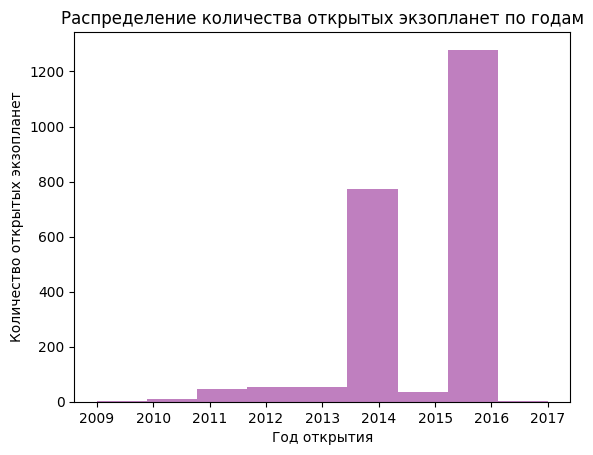

In [41]:
plt.hist(extra_df['disc_year'], alpha = 0.5, bins=int(extra_df['disc_year'].max()-extra_df['disc_year'].min() + 1), color='purple')
plt.xlabel('Год открытия')
plt.ylabel('Количество открытых экзопланет')
plt.title('Распределение количества открытых экзопланет по годам')
plt.show()

Из гистограммы видно, что большая часть планет была открыта после 2014 года. Исторически причиной этого может служить изменение подхода к миссии Кеплера (из-за ряда техническим трудностей) в 2014 году, когда она была переосмысленна и названа "К2".

### Построим столбчатую диаграмму распределения значений disposition

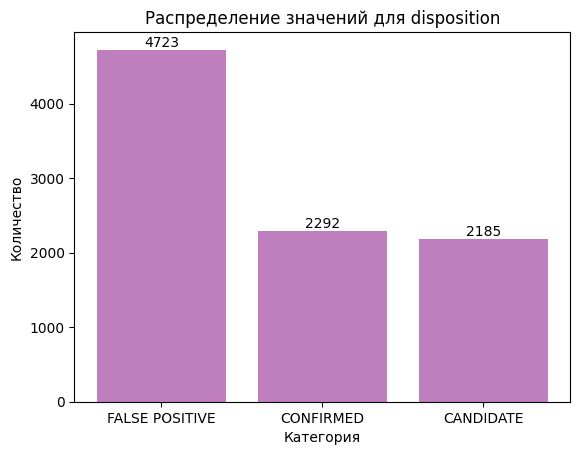

In [53]:
disposition_counts = df['disposition'].value_counts()

# Построим столбчатую диаграмму
plt.bar(disposition_counts.index, disposition_counts.values, alpha=0.5, color='purple')
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.title('Распределение значений для disposition')

# Подпишем столбцы
for i, value in enumerate(disposition_counts.values):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.show()

### Оценим распределение значений интервалов между транзитами.

In [43]:
df.describe()['period']

count      9200.000000
mean         74.315762
std        1360.612589
min           0.241843
25%           2.683239
50%           9.300443
75%          36.873842
max      129995.778400
Name: period, dtype: float64

Как видно, 75% объектов имеют значение интервала между транзитами равным менее 37 дней.

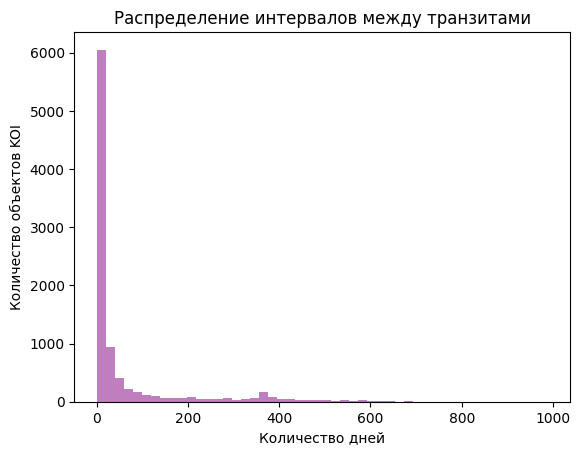

In [44]:

plt.hist(df[df['period'] < 1000.0]['period'], alpha = 0.5, bins = 50, color='purple')
plt.xlabel('Количество дней')
plt.ylabel('Количество объектов KOI')
plt.title('Распределение интервалов между транзитами')
plt.show()


Значения интервалов имеют ощутимые выбросы, что затрудняет их визуализацию.

Визуализация радиусов KOI также не представляется возможной из-за больших выбросов и концентрации более половины значений ниже показателя 10 земных Радиусов.

In [45]:
df['prad'].describe()

count      9200.000000
mean        102.897725
std        3077.806350
min           0.080000
25%           1.400000
50%           2.390000
75%          14.930000
max      200346.000000
Name: prad, dtype: float64

### Построим столбчатую диаграмму распределения значений количества планет и звезд в системах с экзопланетами.

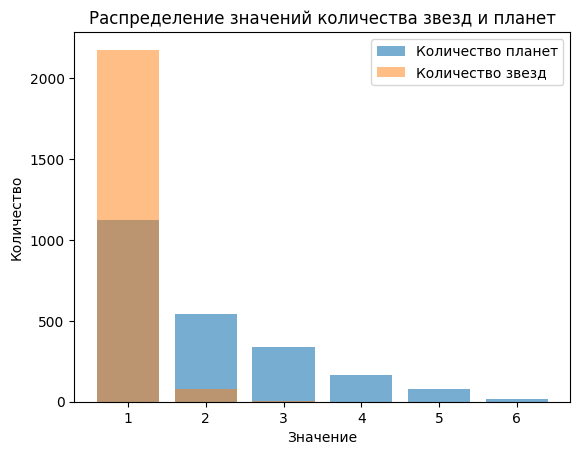

In [46]:
# Получим суммарное количество планет и звезд для каждого объекта
sy_snum_counts = extra_df['sy_snum'].value_counts()
sy_pnum_counts = extra_df['sy_pnum'].value_counts()

# Построим столбчатую диаграмму
plt.bar(sy_pnum_counts.index, sy_pnum_counts.values, alpha=0.6, label='Количество планет')
plt.bar(sy_snum_counts.index, sy_snum_counts.values, alpha=0.5, label='Количество звезд')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.title('Распределение значений количества звезд и планет')
plt.legend()
plt.show()

Из данных видно, что количественно, больше всего систем с экзопланетами, в которых число планет равно 1, чем систем с другим количеством планет. Однако более чем в половине всех случаев, системы, в которых есть экзопланеты, также имеют еще несколько планет.

Случаи систем более чем с 1 звездой - редки.

### Построим гистограмму распределения значений температуры звезд, вокруг которых шел поиск экзопланет

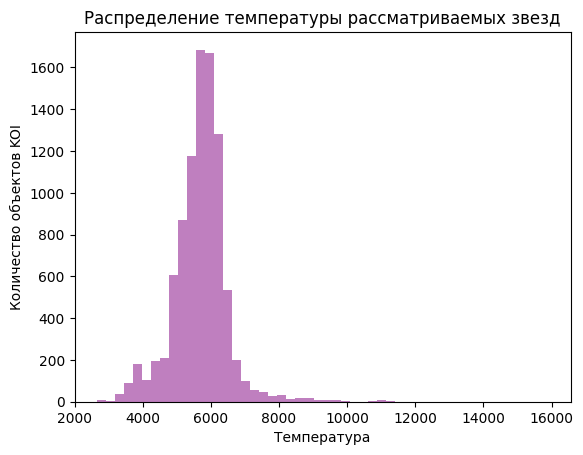

In [47]:
plt.hist(df['steff'], bins = 50, alpha = 0.5, color='purple')
plt.xlabel('Температура')
plt.ylabel('Количество объектов KOI')
plt.title('Распределение температуры рассматриваемых звезд')
plt.show()

Как видим, распределение похоже на нормальное.

### Оценим распределение значений бинарных переменных

Напомним:

- `fpflag_nt` - Принимает значение 1, в случае, если кривая блеска объекта не похожа на кривую блеска транзитной планеты (включает случаи артефактов или большой зашумленности данных), в противном случае - 0.

- `fpflag_ss` - Принимает значение 1, в случае, если данные об объекте выглядят смешанными со вторичными (например в случае с двузвездными системами), в протвином случае - 0.

- `fpflag_co` - Принимает значение 1, в случае, если источником сигнала является близлежайшая звезда (высчитывается физически), в противном случае - 0.

- `fpflag_ec` - Принимает значение 1, в случае, если объект имеет тот же период и другие характеристики, что и какой-то другой объект, в противном случае - 0.

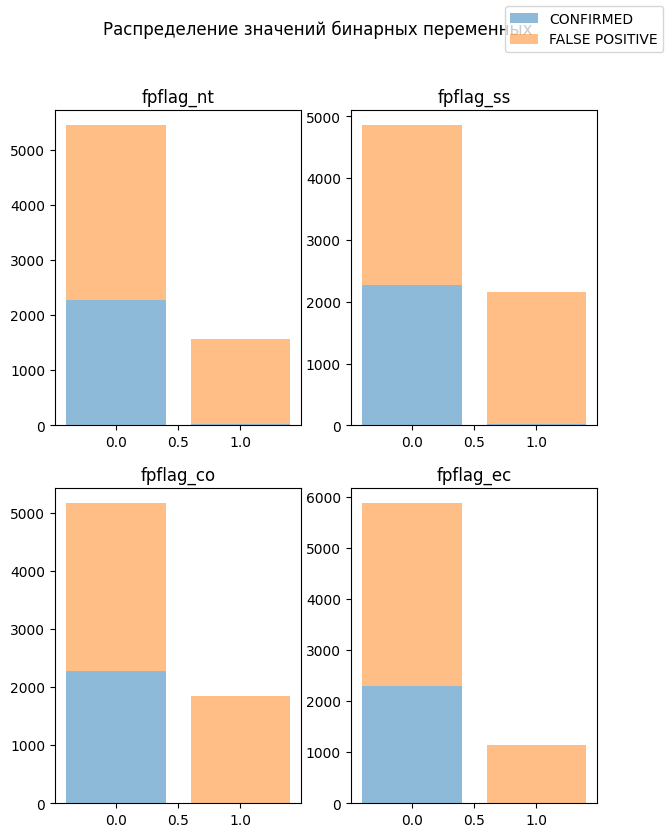

In [48]:
tmp = df[df['disposition'].isin(['CONFIRMED', 'FALSE POSITIVE'])]

# Подсчет количества значений для каждой колонки
nt_counts = tmp.groupby('disposition')['fpflag_nt'].value_counts().unstack()
ss_counts = tmp.groupby('disposition')['fpflag_ss'].value_counts().unstack()
co_counts = tmp.groupby('disposition')['fpflag_co'].value_counts().unstack()
ec_counts = tmp.groupby('disposition')['fpflag_ec'].value_counts().unstack()

# Построение столбчатых диаграмм
fig, axs = plt.subplots(2, 2, figsize=(7, 9))
axs[0, 0].bar(nt_counts.columns, nt_counts.loc['CONFIRMED'], alpha = 0.5, label='CONFIRMED')
axs[0, 0].bar(nt_counts.columns, nt_counts.loc['FALSE POSITIVE'], alpha = 0.5, bottom=nt_counts.loc['CONFIRMED'], label='FALSE POSITIVE')
axs[0, 0].set_title('fpflag_nt')
axs[0, 1].bar(ss_counts.columns, ss_counts.loc['CONFIRMED'], alpha = 0.5)
axs[0, 1].bar(ss_counts.columns, ss_counts.loc['FALSE POSITIVE'], alpha = 0.5, bottom=ss_counts.loc['CONFIRMED'])
axs[0, 1].set_title('fpflag_ss')
axs[1, 0].bar(co_counts.columns, co_counts.loc['CONFIRMED'], alpha = 0.5)
axs[1, 0].bar(co_counts.columns, co_counts.loc['FALSE POSITIVE'], alpha = 0.5, bottom=co_counts.loc['CONFIRMED'])
axs[1, 0].set_title('fpflag_co')
axs[1, 1].bar(ec_counts.columns, ec_counts.loc['CONFIRMED'], alpha = 0.5)
axs[1, 1].bar(ec_counts.columns, ec_counts.loc['FALSE POSITIVE'], alpha = 0.5, bottom=ec_counts.loc['CONFIRMED'])
axs[1, 1].set_title('fpflag_ec')
fig.suptitle('Распределение значений бинарных переменных')
fig.legend()
plt.show()

Рассмотрим количество подтвержденных экзопланет, для которых значения бинарных переменных, отражающих неоднозначность данных, равны 1. 

In [49]:
df4 = df[df['disposition'] == 'CONFIRMED']

# Выведем результаты
print('Количество экзопланет со значением 1 для fpflag_nt:', (df4['fpflag_nt'] == 1).sum())
print('Количество экзопланет со значением 1 для fpflag_ss:', (df4['fpflag_ss'] == 1).sum())
print('Количество экзопланет со значением 1 для fpflag_co:', (df4['fpflag_co'] == 1).sum())
print('Количество экзопланет со значением 1 для fpflag_ec:', (df4['fpflag_ec'] == 1).sum())

Количество экзопланет со значением 1 для fpflag_nt: 21
Количество экзопланет со значением 1 для fpflag_ss: 26
Количество экзопланет со значением 1 для fpflag_co: 6
Количество экзопланет со значением 1 для fpflag_ec: 1


В конечном итоге видим, что непопадание в данные группы не гарантирует, что объект является экзопланетой, так же, как и попадание в данные группы не понижает шанс на то, что объект является экзопланетой, до нуля.

### Отобразим матрицу корреляций для наших данных

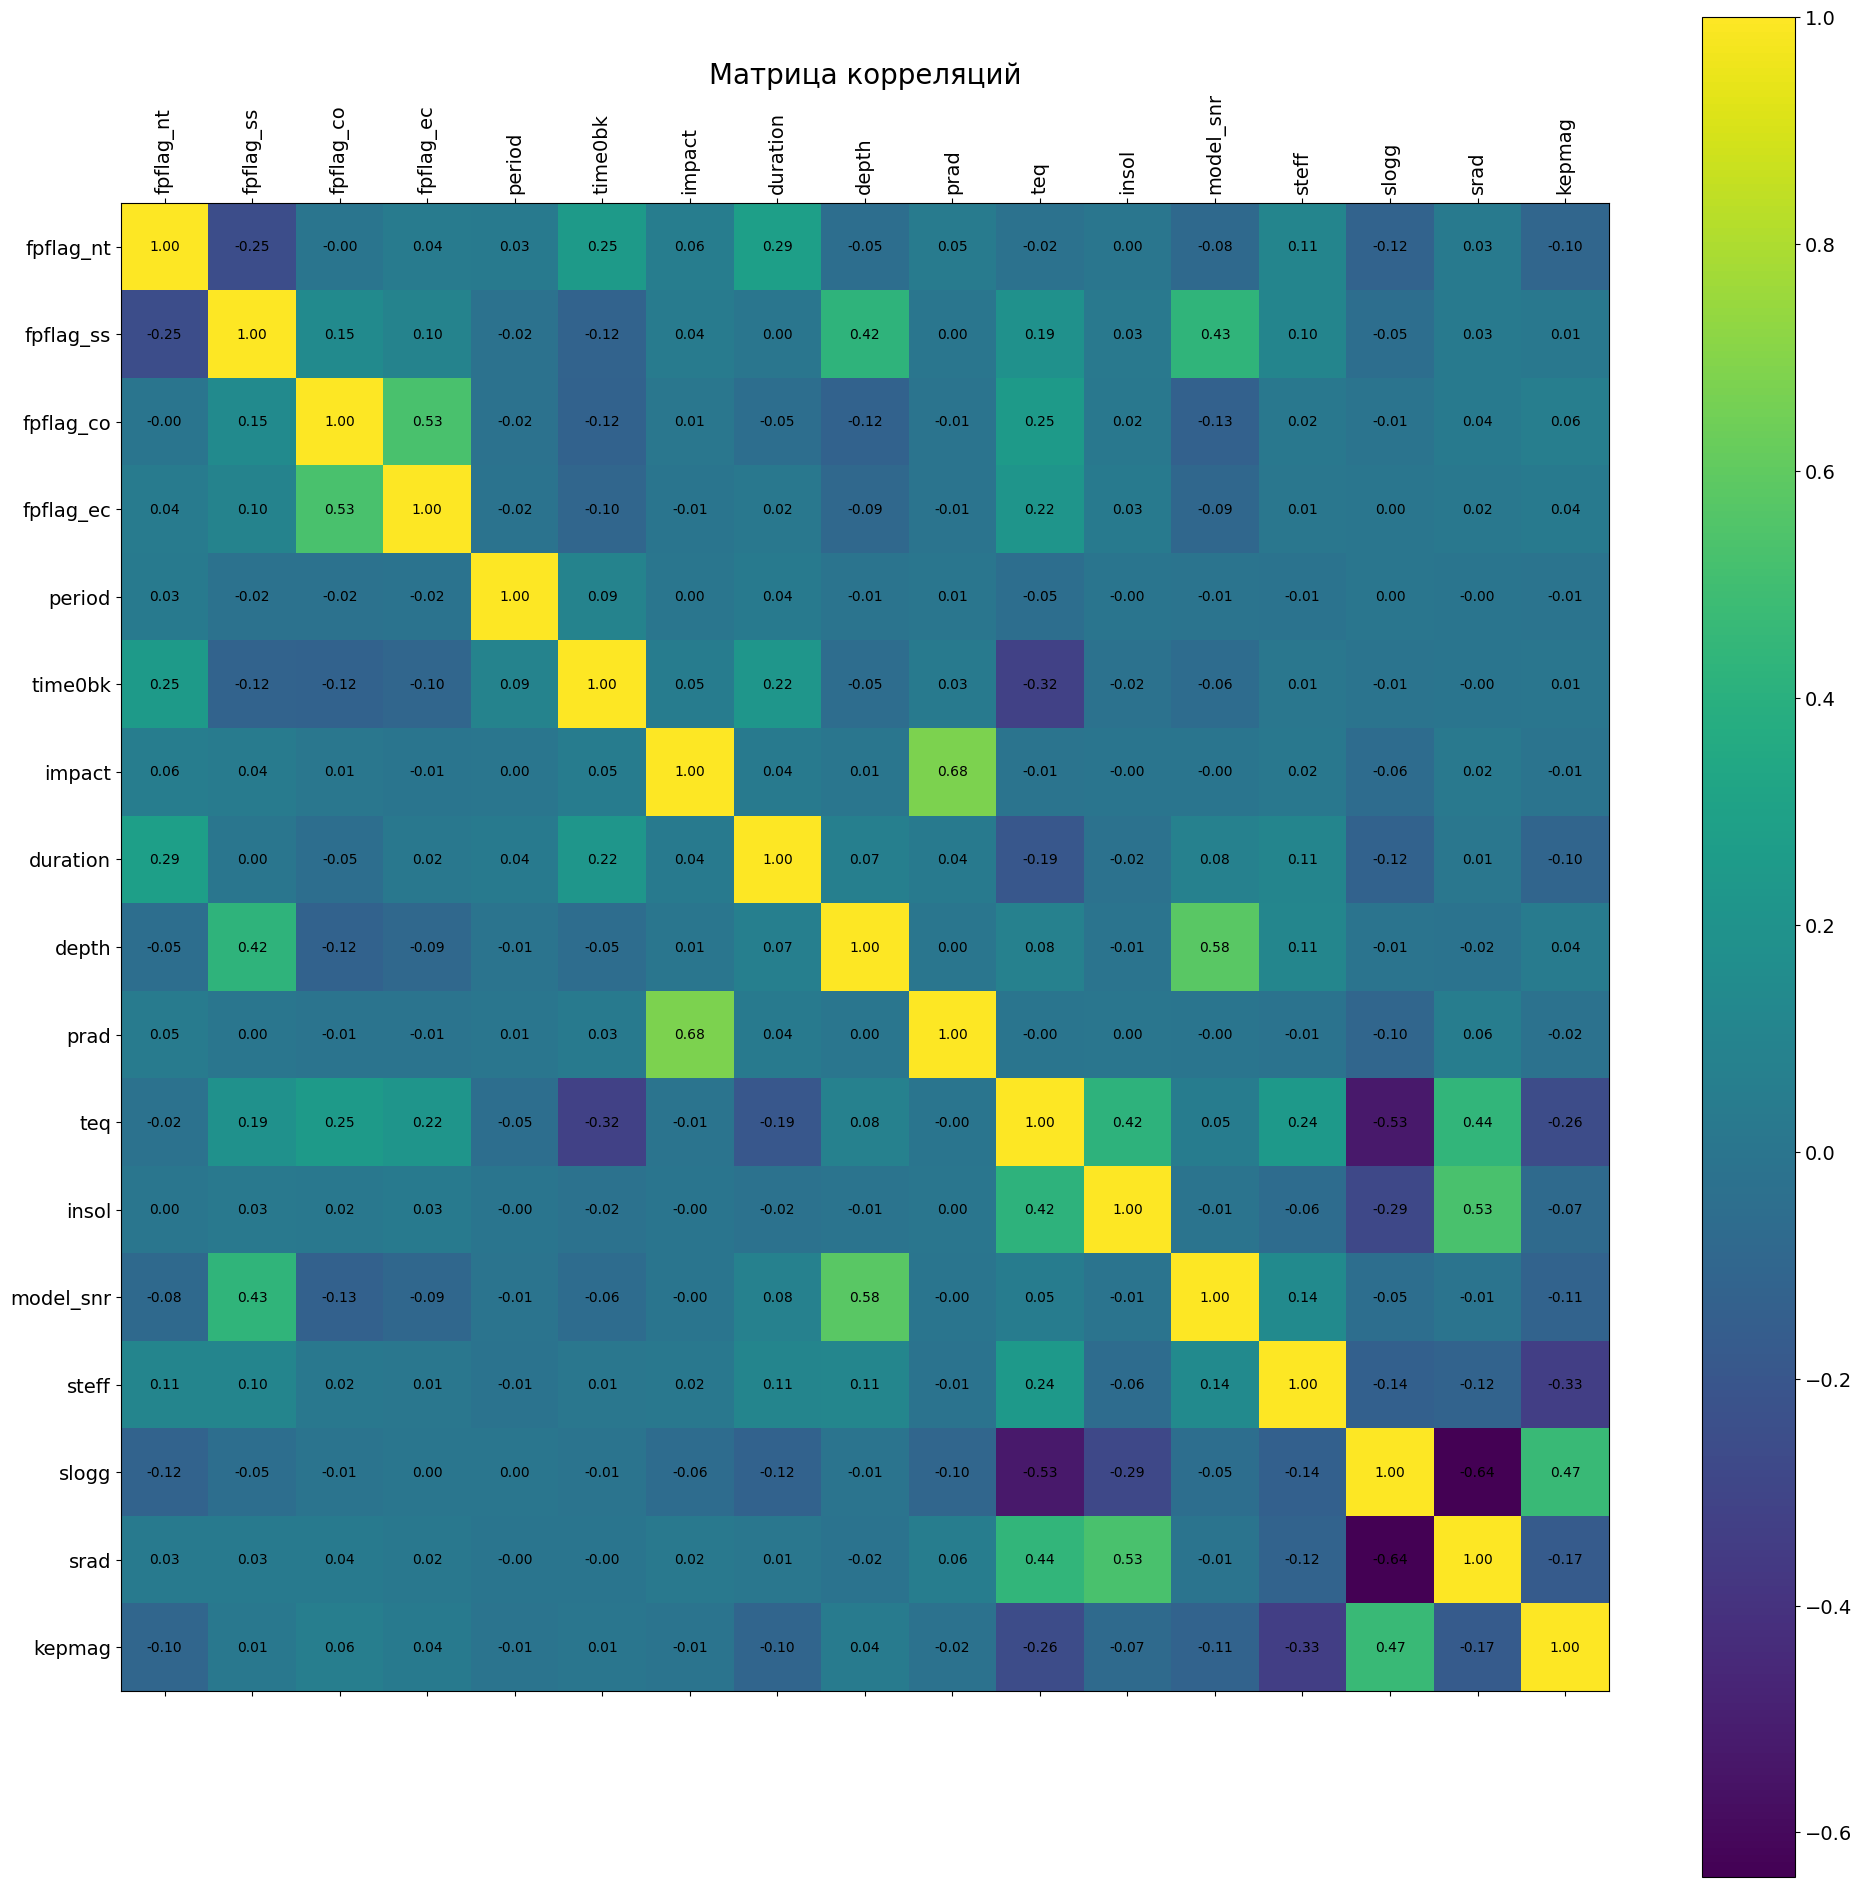

In [50]:
f = plt.figure(figsize=(24, 24))
plt.matshow(df.corr(numeric_only=True), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Матрица корреляций', fontsize=20);

# Подпишем значения корреляций для пар
for (i, j), z in np.ndenumerate(df.corr(numeric_only=True)):
    plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

Рассмотрим пары с самыми большими значениями корреляции:

In [54]:
# Создадим матрицу корреляций
corr_matrix = df.corr(numeric_only=True)

# Найдем самые коррелирующие пары переменных
corr_pairs = corr_matrix.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort", ascending=False)

# Выведем самые коррелирующие пары переменных без повторов и самопар
print('Самые коррелирующие пары переменных:', end='\n\n')
seen_pairs = set()
for pair, corr in sorted_pairs.items():
    var1, var2 = pair
    if var1 != var2:
        if (var1, var2) not in seen_pairs and (var2, var1) not in seen_pairs and corr > 0.2:
            print(f'{var1} - {var2}: {corr:.2f}')
            seen_pairs.add((var1, var2))

Самые коррелирующие пары переменных:

impact - prad: 0.68
model_snr - depth: 0.58
srad - insol: 0.53
fpflag_ec - fpflag_co: 0.53
slogg - kepmag: 0.47
teq - srad: 0.44
fpflag_ss - model_snr: 0.43
fpflag_ss - depth: 0.42
insol - teq: 0.42
fpflag_nt - duration: 0.29
fpflag_nt - time0bk: 0.25
fpflag_co - teq: 0.25
steff - teq: 0.24
time0bk - duration: 0.22
teq - fpflag_ec: 0.22


Пара `impact - prad` звучит более менее логично, связь между радиусом объекта и его расстоянием до центра звезды может иметь право на существование. Высокие показатели `model_snr - depth` вызваны тем, что мы считаем model_snr при помощи depth. 

В паре `srad - insol` наблюдаем интересную возможную связь между радиусом звезды и теплом, которое получает от звезды объект. Пара `teq - srad` аналогична предыдущей, так как teq обозначает температуру объекта.

## Часть 4: Гипотезы

Проведенные в предыдущем пункте визуализация и анализ данных, а также собственное критическое мышление позволили нам выдвинуть ряд гипотез, справедливость которых будет рассмотрена ниже.

### Существует корреляция между периодом транзита экзопланеты и ее радиусом

In [63]:
data = df[['period', 'prad']]

# Вычислим коэффициент корреляции Пирсона
corr, p_value = pearsonr(data['period'], data['prad'])

# Выведем результаты
if p_value < 0.05:
    print('Существует статистически значимая корреляция между периодом транзита экзопланеты и ее радиусом.')
else:
    print('Недостаточно доказательств, чтобы говорить о корреляции.')

Недостаточно доказательств, чтобы говорить о корреляции.


### Существует корреляция между радиусами объекта и звезды

In [65]:
data = df[['srad', 'prad']]

# Вычислим коэффициент корреляции Пирсона
corr, p_value = pearsonr(data['srad'], data['prad'])

# Выведем результаты
if p_value < 0.05:
    print('Существует статистически значимая корреляция между радиусами объекта и звезды.')
else:
    print('Недостаточно доказательств, чтобы говорить о корреляции.')

Существует статистически значимая корреляция между радиусами объекта и звезды.


### Существует корреляция между массами экзопланеты и ее звезды

In [67]:
data = extra_df[['pl_bmasse', 'st_mass']].dropna()

# Вычислим коэффициент корреляции Пирсона
corr, p_value = pearsonr(data['pl_bmasse'], data['st_mass'])

# Выведем результаты
if p_value < 0.05:
    print('Существует статистически значимая корреляция между массами экзопланеты и ее звезды.')
else:
    print('Недостаточно доказательств, чтобы говорить о корреляции.')

Существует статистически значимая корреляция между массами экзопланеты и ее звезды.


### Существует корреляция между годом открытия экзопланеты и количеством планет в ее системе

In [71]:
data = extra_df[['disc_year', 'sy_pnum']].dropna()

# Вычислим коэффициент корреляции Пирсона
corr, p_value = pearsonr(data['disc_year'], data['sy_pnum'])

# Выведем результаты
if p_value < 0.05:
    print('Существует статистически значимая корреляция между годом открытия экзопланеты и количеством планет в ее системе.')
else:
    print('Недостаточно доказательств, чтобы говорить о корреляции.')

Существует статистически значимая корреляция между годом открытия экзопланеты и количеством планет в ее системе.


### Существует корреляция между длительностью транзита экзопланеты и ее радиусом

In [56]:
data = df[['duration', 'prad']]

# Вычислим коэффициент корреляции Пирсона
corr, p_value = pearsonr(data['duration'], data['prad'])

# Выведем результаты
if p_value < 0.05:
    print('Существует статистически значимая корреляция между длительностью транзита экзопланеты и ее радиусом.')
else:
    print('Недостаточно доказательств, чтобы говорить о корреляции.')

Существует статистически значимая корреляция между длительностью транзита экзопланеты и ее радиусом.


### Существует корреляция между массой звезды и количеством планет в системе.

In [57]:
data = extra_df[['st_mass', 'sy_pnum']].dropna()

# Вычислим коэффициент корреляции Пирсона
corr, p_value = pearsonr(data['st_mass'], data['sy_pnum'])

# Выведем результаты
if p_value < 0.05:
    print('Существует статистически значимая корреляция между массой звезды и количеством планет в системе.')
else:
    print('Недостаточно доказательств, чтобы говорить о корреляции.')

Существует статистически значимая корреляция между массой звезды и количеством планет в системе.


###  Есть статистически значимая разница в периодах транзитов между подтвержденными экзопланетами, кандидатами и ложными срабатываниями.

In [58]:
confirmed = df[df['disposition'] == 'CONFIRMED']['period']
candidate = df[df['disposition'] == 'CANDIDATE']['period']
false_positive = df[df['disposition'] == 'FALSE POSITIVE']['period']

# Выполним однофакторный дисперсионный анализ (ANOVA)
f_stat, p_value = f_oneway(confirmed, candidate, false_positive)

# Выведем результаты
if p_value < 0.05:
    print('Существует статистически значимая разница в периодах транзитов между подтвержденными экзопланетами, кандидатами и ложными срабатываниями.')
else:
    print('Недостаточно доказательств, чтобы говорить о корреляции.')

Существует статистически значимая разница в периодах транзитов между подтвержденными экзопланетами, кандидатами и ложными срабатываниями.


### Есть статистически значимая разница в температуре экзопланет между подтвержденными экзопланетами, кандидатами и ложными срабатываниями.

In [59]:
confirmed = df[df['disposition'] == 'CONFIRMED']['teq']
candidate = df[df['disposition'] == 'CANDIDATE']['teq']
false_positive = df[df['disposition'] == 'FALSE POSITIVE']['teq']

# Выполним t-тест для независимых выборок
t_stat, p_value = ttest_ind(confirmed, candidate)

# Выводем результаты
if p_value < 0.05:
    print('Существует статистически значимая разница в температуре экзопланет между подтвержденными экзопланетами и кандидатами.')
else:
    print('Недостаточно доказательств, чтобы говорить о корреляции.')

# Выполним t-тест для независимых выборок
t_stat, p_value = ttest_ind(confirmed, false_positive)

# Выведем результаты
if p_value < 0.05:
    print('Существует статистически значимая разница в температуре экзопланет между подтвержденными экзопланетами и ложными срабатываниями.')
else:
    print('Недостаточно доказательств, чтобы говорить о корреляции.')

Существует статистически значимая разница в температуре экзопланет между подтвержденными экзопланетами и кандидатами.
Существует статистически значимая разница в температуре экзопланет между подтвержденными экзопланетами и ложными срабатываниями.


### Существует корреляция между радиусом звезды и теплом, получаемым объектом

In [60]:
data = df[['srad', 'insol']]

# Вычислим коэффициент корреляции Пирсона
corr, p_value = pearsonr(data['srad'], data['insol'])

# Выведем результаты
if p_value < 0.05:
    print('Существует статистически значимая корреляция между радиусом звезды и теплом, получаемым объектом.')
else:
    print('Недостаточно доказательств, чтобы говорить о корреляции.')

Существует статистически значимая корреляция между радиусом звезды и теплом, получаемым объектом.


### Cредняя температура экзопланет отличается между подтвержденными экзопланетами и кандидатами.

In [72]:
# Выполним t-тест для независимых выборок
t_stat, p_value = ttest_ind(confirmed, candidate)

# Выведем результаты
if p_value < 0.05:
    print('Существует статистически значимая разница в средней температуре экзопланет между подтвержденными экзопланетами и кандидатами.')
else:
    print('Недостаточно доказательств, чтобы говорить о корреляции.')

Существует статистически значимая разница в средней температуре экзопланет между подтвержденными экзопланетами и кандидатами.


## Часть 5: Машинное обучение

В нашем случае наиболее логично будет попытаться обучить классификатор, чтобы он мог по данным объекта (признаковому описанию) попытаться получить целевую переменную `disposition`. Как уже известно, она принимает значения: CANDIDATE, CONFIRMED, FALSE POSITIVE. 

В качестве данных используем DataFrame `df`, так как обогащенный `extra_df` содержит излишнюю несимметричную со всеми строками дополнительную информацию по подтвержденным экзопланетам.

Будем обучать модели:

- `LogisticRegression`

- `RandomForestClassifier`

- `DecisionTreeClassifier`

- `GaussianNB`

Также будем использовать метод GridSearch для подбора лучших гиперпараметров.

In [61]:
# Разделим данные на признаковые описания и целевую переменную
X = df.drop('disposition', axis=1)
X = X.drop('kepler_name', axis=1)
X = X.drop('kepoi_name', axis=1)
y = df['disposition']

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# Предварительная обработка данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### LogisticRegression

In [27]:
param_grid = {
    'solver': ['lbfgs', 'saga', 'liblinear', 'newton-cg'],
    'C': [0.1, 1, 10]
}

logreg = LogisticRegression(max_iter=100000)

# Создание объекта GridSearchCV
grid_search = GridSearchCV(logreg, param_grid, cv=5)

# Обучение модели с использованием GridSearchCV
grid_search.fit(X_train, y_train)

# Вывод лучших параметров
print('Лучшие параметры для логистической регрессии:', grid_search.best_params_)

# Обучение модели с использованием лучших параметров
logreg_best = LogisticRegression(**grid_search.best_params_)
logreg_best.fit(X_train, y_train)

# Оценка качества модели
y_pred_logreg_best = logreg_best.predict(X_test)
print('Точность: {:.2f}'.format(accuracy_score(y_test, y_pred_logreg_best)))

Лучшие параметры для логистической регрессии: {'C': 10, 'solver': 'newton-cg'}
Точность: 0.82


### RandomForestClassifier

In [29]:
param_grid_rf = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 40]
}

rf = RandomForestClassifier()

# Создание объекта GridSearchCV
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5)

# Обучение модели с использованием GridSearchCV
grid_search_rf.fit(X_train, y_train)

# Вывод лучших параметров
print('Лучшие параметры для RadndomForest:', grid_search_rf.best_params_)

# Обучение модели с использованием лучших параметров
rf_best = RandomForestClassifier(**grid_search_rf.best_params_)
rf_best.fit(X_train, y_train)

# Оценка качества модели
y_pred_rf_best = rf_best.predict(X_test)
print('Точность: {:.2f}'.format(accuracy_score(y_test, y_pred_rf_best)))

Лучшие параметры для RadndomForest: {'max_depth': 40, 'n_estimators': 100}
Точность: 0.89


### DecisionTreeClassifier

In [33]:
param_grid_dt = {
    'max_depth': [None, 10, 20]
}

dt = DecisionTreeClassifier()

# Создание объекта GridSearchCV
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5)

# Обучение модели с использованием GridSearchCV
grid_search_dt.fit(X_train, y_train)

# Вывод лучших параметров
print('Лучшие параметры для Decision tree:', grid_search_dt.best_params_)

# Обучение модели с использованием лучших параметров
dt_best = DecisionTreeClassifier(**grid_search_dt.best_params_)
dt_best.fit(X_train, y_train)

# Оценка качества модели
y_pred_dt_best = dt_best.predict(X_test)
print('Точность: {:.2f}'.format(accuracy_score(y_test, y_pred_dt_best)))

Лучшие параметры для Decision tree: {'max_depth': 10}
Точность: 0.89


### GaussianNB

In [31]:
# Определение параметров для поиска по сетке
param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}

nb = GaussianNB()

# Создание объекта GridSearchCV
grid_search_nb = GridSearchCV(nb, param_grid_nb, cv=5)

# Обучение модели с использованием GridSearchCV
grid_search_nb.fit(X_train, y_train)

# Вывод лучших параметров
print('Лучшие параметры для GaussianNB:', grid_search_nb.best_params_)

# Обучение модели с использованием лучших параметров
nb_best = GaussianNB(**grid_search_nb.best_params_)
nb_best.fit(X_train, y_train)

# Оценка качества модели
y_pred_nb_best = nb_best.predict(X_test)
print('Точность: {:.2f}'.format(accuracy_score(y_test, y_pred_nb_best)))

Лучшие параметры для GaussianNB: {'var_smoothing': 1e-08}
Точность: 0.80


В конечном итоге самые лучшие показатели имеют модели `RandomForestClassifier` и `DecisionTreeClassifier`, которые имеют 89% точность в классификации объекта относительно целевой переменной `disposition`.

## Вывод

В итоге нами были достигнуты поставленные цели. Датасет оказался достаточно трудным для анализа, имел много колонок, однако его детальное рассмотрение позволило откинуть избыточные столбцы. 

В ходе работы мы обогатили наш датасет данными из другого датасета, сообщив дополнительную информацию об экзопланетах. Обучение моделей прошло успешно, самая удачная модель имеет показатель точности равный 89%.